In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [30]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [3]:
data = os.chdir(r"C:\Users\CC\Downloads")
data = pd.read_csv('perrin-freres-monthly-champagne.csv',parse_dates=True,index_col=0)

In [4]:
data

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 1964-01-01 to 1972-09-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   105 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB


In [6]:
data.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


In [7]:
data['Year']=data.index.year
data['Months']=data.index.month_name()

In [8]:
data.head()

,Sales,Year,Months
Month,,,
1964-01-01,2815,1964,January
1964-02-01,2672,1964,February
1964-03-01,2755,1964,March
1964-04-01,2721,1964,April
1964-05-01,2946,1964,May


# Exploratory Data Analysis

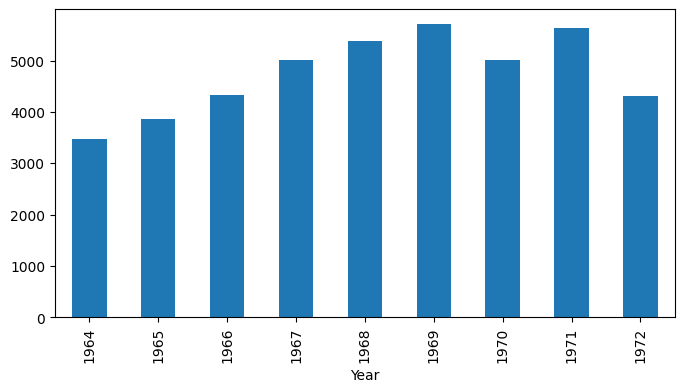

In [9]:
plt.figure(figsize=(8,4))
data.groupby('Year')['Sales'].mean().plot(kind='bar')
plt.show()

There is a gradual increase in sales between 1964 and 1969 and an uncertainty of increase and decrease between 1970 and 1972. It is clear that it has seasonality.

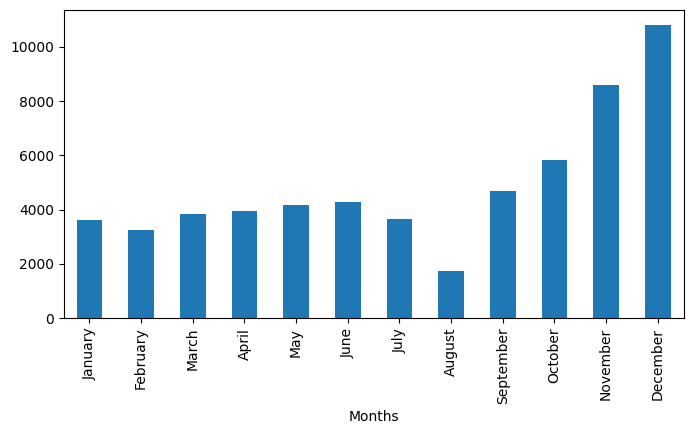

In [10]:
plt.figure(figsize=(8,4))
data.groupby('Months')['Sales'].mean().reindex(index=['January','February','March','April','May','June','July','August','September','October','November','December']).plot(kind='bar')
plt.show()

From above plot it is obvious that Sales from January to July is nearly same and experienced a fall in August. The figure climbed rapidly from September to December.

In [11]:
month=pd.pivot_table(data,values='Sales',index='Months',columns='Year')
month=month.reindex(index=['January','February','March','April','May','June','July','August','September','October','November','December'])

In [12]:
month

Year,1964,1965,1966,1967,1968,1969,1970,1971,1972
Months,,,,,,,,,
January,2815.0,2541.0,3113.0,5375.0,3633.0,4016.0,2639.0,3934.0,4348.0
February,2672.0,2475.0,3006.0,3088.0,4292.0,3957.0,2899.0,3162.0,3564.0
March,2755.0,3031.0,4047.0,3718.0,4154.0,4510.0,3370.0,4286.0,4577.0
April,2721.0,3266.0,3523.0,4514.0,4121.0,4276.0,3740.0,4676.0,4788.0
May,2946.0,3776.0,3937.0,4520.0,4647.0,4968.0,2927.0,5010.0,4618.0
June,3036.0,3230.0,3986.0,4539.0,4753.0,4677.0,3986.0,4874.0,5312.0
July,2282.0,3028.0,3260.0,3663.0,3965.0,3523.0,4217.0,4633.0,4298.0
August,2212.0,1759.0,1573.0,1643.0,1723.0,1821.0,1738.0,1659.0,1413.0
September,2922.0,3595.0,3528.0,4739.0,5048.0,5222.0,5221.0,5951.0,5877.0


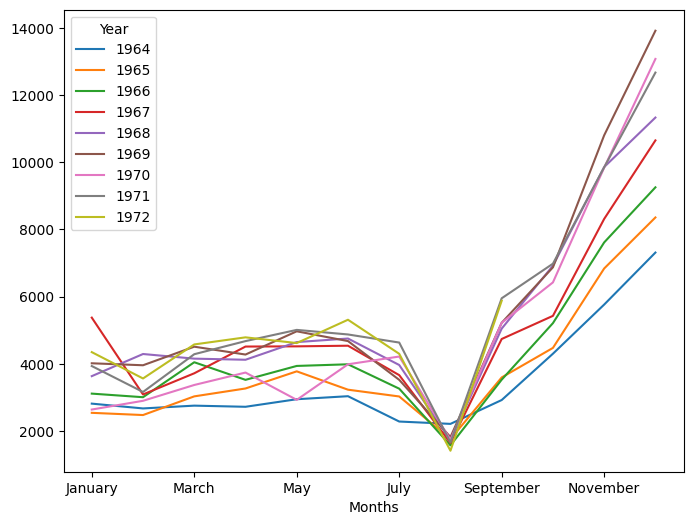

In [13]:
month.plot(figsize=(8,6))
plt.show()

Yearly observations show that sales reamin more or less constant from January to July but there is a steep fall at the month of August and a rapid increase after that.

<Axes: xlabel='Month'>

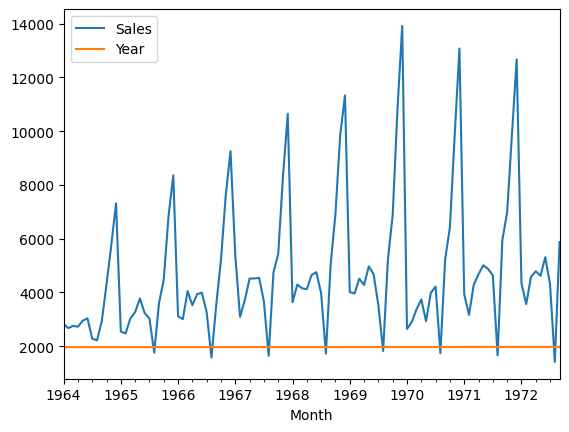

In [14]:
data.plot()

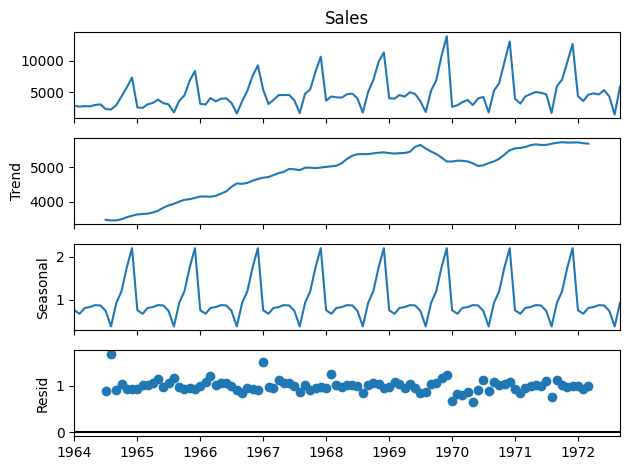

In [15]:
from statsmodels.tsa.seasonal import seasonal_decompose

seaonal=seasonal_decompose(data['Sales'],model='multiplicative')
seaonal.plot()
plt.show()

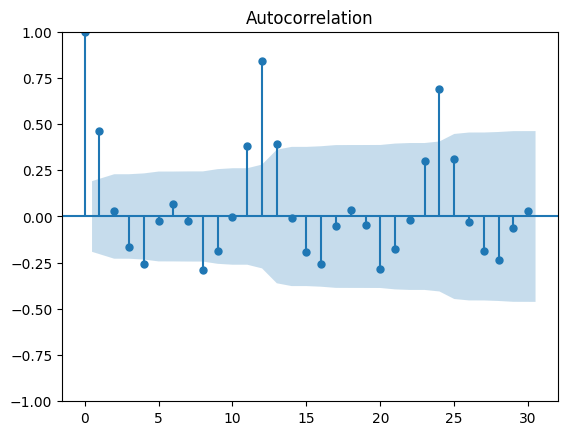

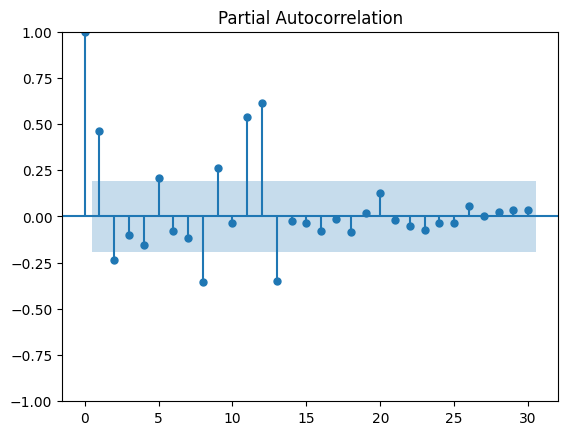

In [16]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(data['Sales'],lags=30)
plot_pacf(data['Sales'],lags=30)
plt.show()

In [17]:
#Ho: The data is non-stationary
##H1: The data is stationary
from statsmodels.tsa.stattools import adfuller

adf_test=adfuller(data['Sales'],autolag='AIC')
print("1. ADF test:",adf_test[0])
print("2. ADF test p-value:",adf_test[1])
print("3. Number of lags :", adf_test[2])

# Check if the time series is stationary
if adf_test[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

1. ADF test: -1.8335930563276237
2. ADF test p-value: 0.3639157716602447
3. Number of lags : 11
The time series is not stationary.


As the p-value(0.3639) is greater than significance level (0.05), we failed to reject the null hypothesis and conclude that the series is non stationary. So we are choosing ARIMA model for forecasting.

# ARIMA Model

In [18]:
# finding difference with shift 1
data['Sales_1st_diff'] = data['Sales'] - data['Sales'].shift(1)
data.head()

,Sales,Year,Months,Sales_1st_diff
Month,,,,
1964-01-01,2815,1964,January,NaN
1964-02-01,2672,1964,February,-143.0
1964-03-01,2755,1964,March,83.0
1964-04-01,2721,1964,April,-34.0
1964-05-01,2946,1964,May,225.0


<Axes: xlabel='Month'>

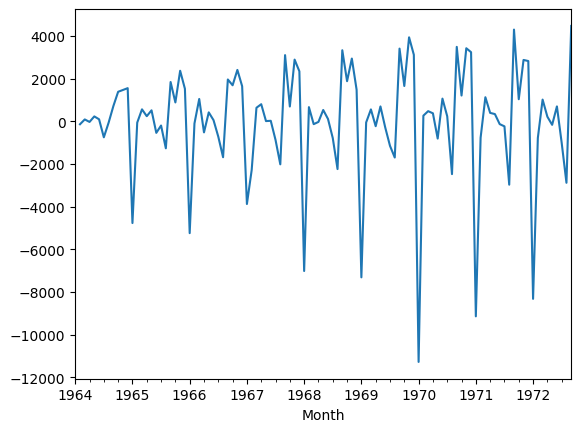

In [19]:
data['Sales_1st_diff'].plot()

In [20]:
adf_test=adfuller(data['Sales_1st_diff'].dropna(),autolag='AIC')
print("1. ADF test:",adf_test[0])
print("2. ADF test p-value:",adf_test[1])
print("3. Number of lags :", adf_test[2])

# Check if the time series is stationary
if adf_test[1] < 0.05:
    print("The time series is stationary.")
else:
    print("The time series is not stationary.")

1. ADF test: -7.1898964480510115
2. ADF test p-value: 2.5196204473869244e-10
3. Number of lags : 11
The time series is stationary.


After doing the difference in our time series data, we found that p-value is less than the significance level (0.05) and hence we reject the null hypothesis and the series is stationary

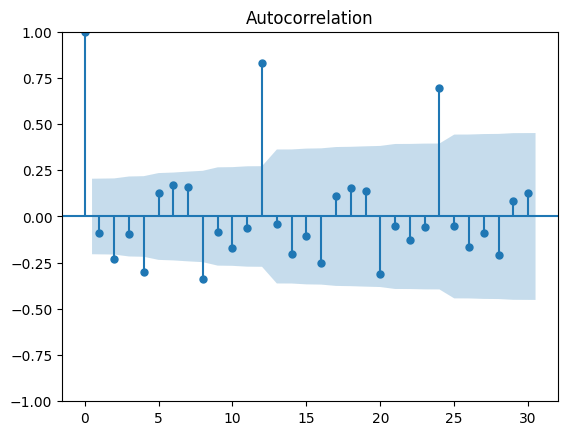

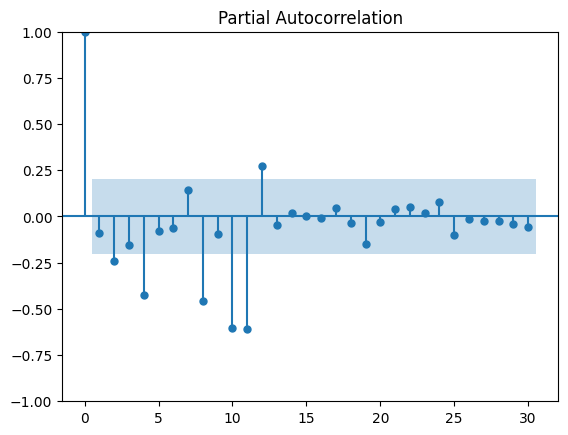

In [21]:
plot_acf(data['Sales_1st_diff'].iloc[13:],lags=30)
plot_pacf(data['Sales_1st_diff'].iloc[13:],lags=30)
plt.show()

From above plots we conclude that value of p can be 1, d can be 1 and q can be either 0 or 1. We choose the order of ARIMA as (1,1,1)

In [31]:
from statsmodels.tsa.arima.model import ARIMA

model_arima=ARIMA(data['Sales'],order=(1,1,1)).fit()
model_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -952.814
Date:                Wed, 07 Jun 2023   AIC                           1911.627
Time:                        23:45:12   BIC                           1919.560
Sample:                    01-01-1964   HQIC                          1914.841
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4545      0.114      3.999      0.000       0.232       0.677
ma.L1         -0.9666      0.056    -17.314      0.000      -1.076      -0.857
sigma2      5.226e+06   6.17e+05      8.473      0.000    4.02e+06    6.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 2.59
Prob(Q):                              0.34   Prob(JB):                         0.27
Heteroskedasticity (H):               3.40   Skew:                             0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
data.shape

(105, 4)

In [24]:
data['pred']=model_arima.predict(start=90,end=105,dynamic=True)

<Axes: xlabel='Month'>

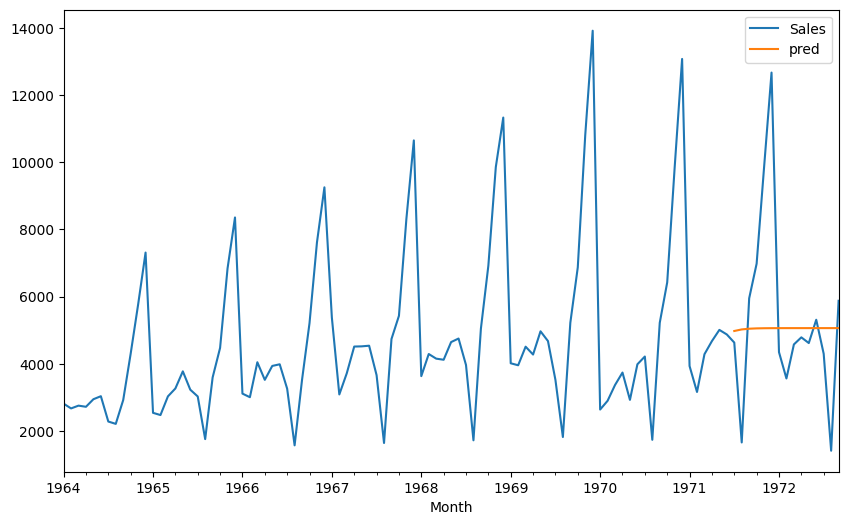

In [25]:
data[['Sales','pred']].plot(figsize=(10,6))

From the plot we can see that our forecast is not efficient as ARIMA model not consider the seasonal part in model building. Hence we can try with Seasonal Arima model.

# Seasonal ARIMA Model

In [32]:
import statsmodels.api as sm

model2=sm.tsa.statespace.SARIMAX(data['Sales'],order=(1,1,1),seasonal_order=(1,1,1,12)).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Sales   No. Observations:                  105
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -738.402
Date:                            Wed, 07 Jun 2023   AIC                           1486.804
Time:                                    23:45:15   BIC                           1499.413
Sample:                                01-01-1964   HQIC                          1491.893
                                     - 09-01-1972                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2790      0.081      3.433      0.001       0.120       0.438
ma.L1         -0.9494      0.043    -22.334      0.000      -1.033      -0.866
ar.S.L12      -0.4544      0.303     -1.499      0.134      -1.049       0.140
ma.S.L12       0.2450      0.311      0.788      0.431      -0.365       0.855
sigma2      5.055e+05   6.12e+04      8.265      0.000    3.86e+05    6.25e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                 8.70
Prob(Q):                              0.61   Prob(JB):                         0.01
Heteroskedasticity (H):               1.18   Skew:                            -0.21
Prob(H) (two-sided):                  0.64   Kurtosis:                         4.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<Axes: xlabel='Month'>

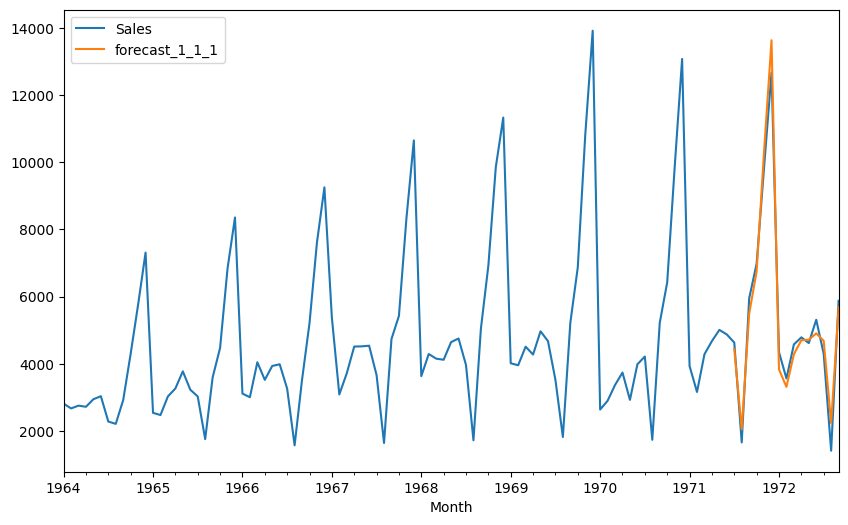

In [27]:
data['forecast_1_1_1']=model2.predict(start=90,end=125,dynamic=True)
data[['Sales','forecast_1_1_1']].plot(figsize=(10,6))

In [28]:
# Forecast for the next 2 years 
forecast = model2.predict(start = len(data),  
                          end = (len(data)-1) + 2 * 12,  
                          typ = 'levels').rename('Forecast') 

<Axes: xlabel='Month'>

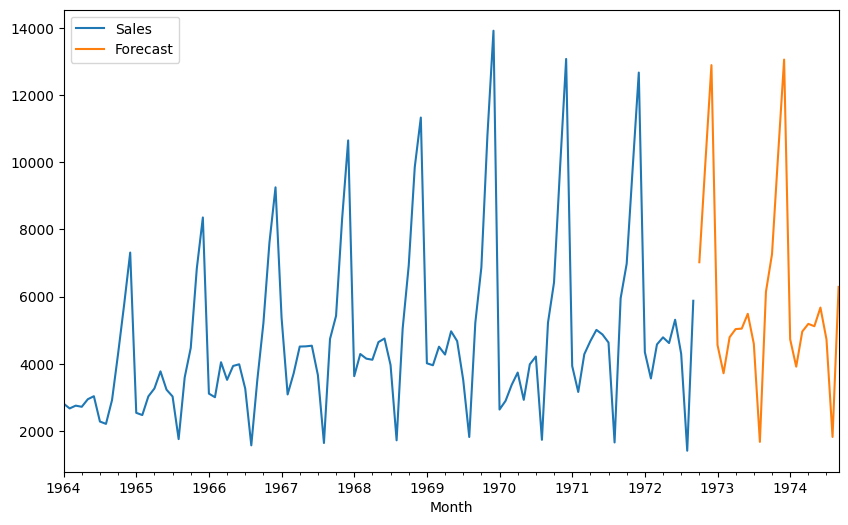

In [29]:
# Plot the forecast values 
data['Sales'].plot(figsize = (10,6), legend = True) 
forecast.plot(legend = True)

From the above plot, we can see the Seasonal ARIMA model has forecasted well. We can say the sales of champagne might be following same pattern for the next 2 years as well.